# 

# Case Study: Designing a Simulation Study

Simulation studies are an ideal setting for utilizing functions. When
conducting a simulation study, we often need to generate data, run
statistical methods, and collect results, and we replicate this for a
large number of simulations. Functions will ensure that we can write
cleaner and reproducible code. In this case study, we will write the
code for a simulation study that is based on the analysis by
@hastie2020best, which compared different methods for sparse regression.
For our purposes, we will focus on the comparison between lasso and
ridge regression, introduced in **?@sec-model-selection**.

Our goal is to understand the predictive power of the two models for
different data settings. We will generate our training and test data
using the following data generating mechanism which relies on the number
of observations $n$, the number of predictors $p$, the sparsity
$s \leq p$, predictor correlation level $\rho$, and $\nu$
signal-to-noise ratio.

1.  We define a vector of coefficients $\beta \in \mathbb{R}^p$ which
    has its first $s$ components equal to 1 and the rest equal to 0.
    Note that our model will not have an intercept.

2.  We draw the rows of the predictor matrix
    $X \in \mathbb{R}^{n \times p}$ from a multivariate normal
    distribution $N_p(0, \Sigma)$, where
    $\Sigma \in \mathbb{R}^{p \times p}$ has entry $(i,j)$ equal to
    \$^{\|i-j\|}.

3.  We draw the outcome $y \in \mathbb{R}^n$ from a normal distribution
    $N(X \beta, \sigma^2 I)$, where
    $\sigma^2 = \frac{\beta \Sigma \beta}{\nu}$. This ensures that the
    data has signal-to-noise ratio, defined as
    $\text{Var}(x^T \beta)/\text{Var}(\sigma^2)$, equal to $\nu$.

After generating our data, we will use 5-fold cross-validation to fit a
lasso or ridge regression model on the training data to get estimated
coefficients $\hat{\beta}$. Last, we will predict on the withheld test
set. The evaluation metrics we are interested in are the time to fit the
model (in seconds), the relative test error

$$\text{RTE} = \frac{(\hat{\beta}-\beta)^T \Sigma (\hat{\beta}-\beta)+\sigma^2}{\sigma^2}, $$

and the proportion of variance explained

$$\text{PVE} = 1 - \frac{(\hat{\beta}-\beta)^T \Sigma (\hat{\beta}-\beta)+\sigma^2}{\beta^T \Sigma \beta + \sigma^2}.$$

In @hastie2020best, they vary all five parameters $n$, $p$, $s$, $\rho$,
and $\nu$ to observe how the data generation impacts these metrics.

## Outlining Our Approach

Before coding our method, let’s recap the steps we will need to perform
for a single simulation and practice top-down programming. In a single
simulation, we need to generate our training and test data, fit our
models, and store the results in a way that we can use later. There are
two potential sketches of how we can program this code shown in
<a href="#fig-sketch" class="quarto-xref">Figure 1</a>. Take a look at
the differences. In the first, we are storing the data we generate and
have a separate function for each method. In the second, we have a
function that calculates our end metrics for an inputted model, and we
have a function that runs through the different methods. A benefit of
the first approach is that it will be more flexible; if we think of
another method we want to compare, we would be easily able to add it
without having to re-run any other code. A benefit of the second
approach is that we are ensuring that the results stored for each method
are the same. Of course, you could also do a hybrid between the two and
use a metrics function in the first approach.

<figure id="fig-sketch">
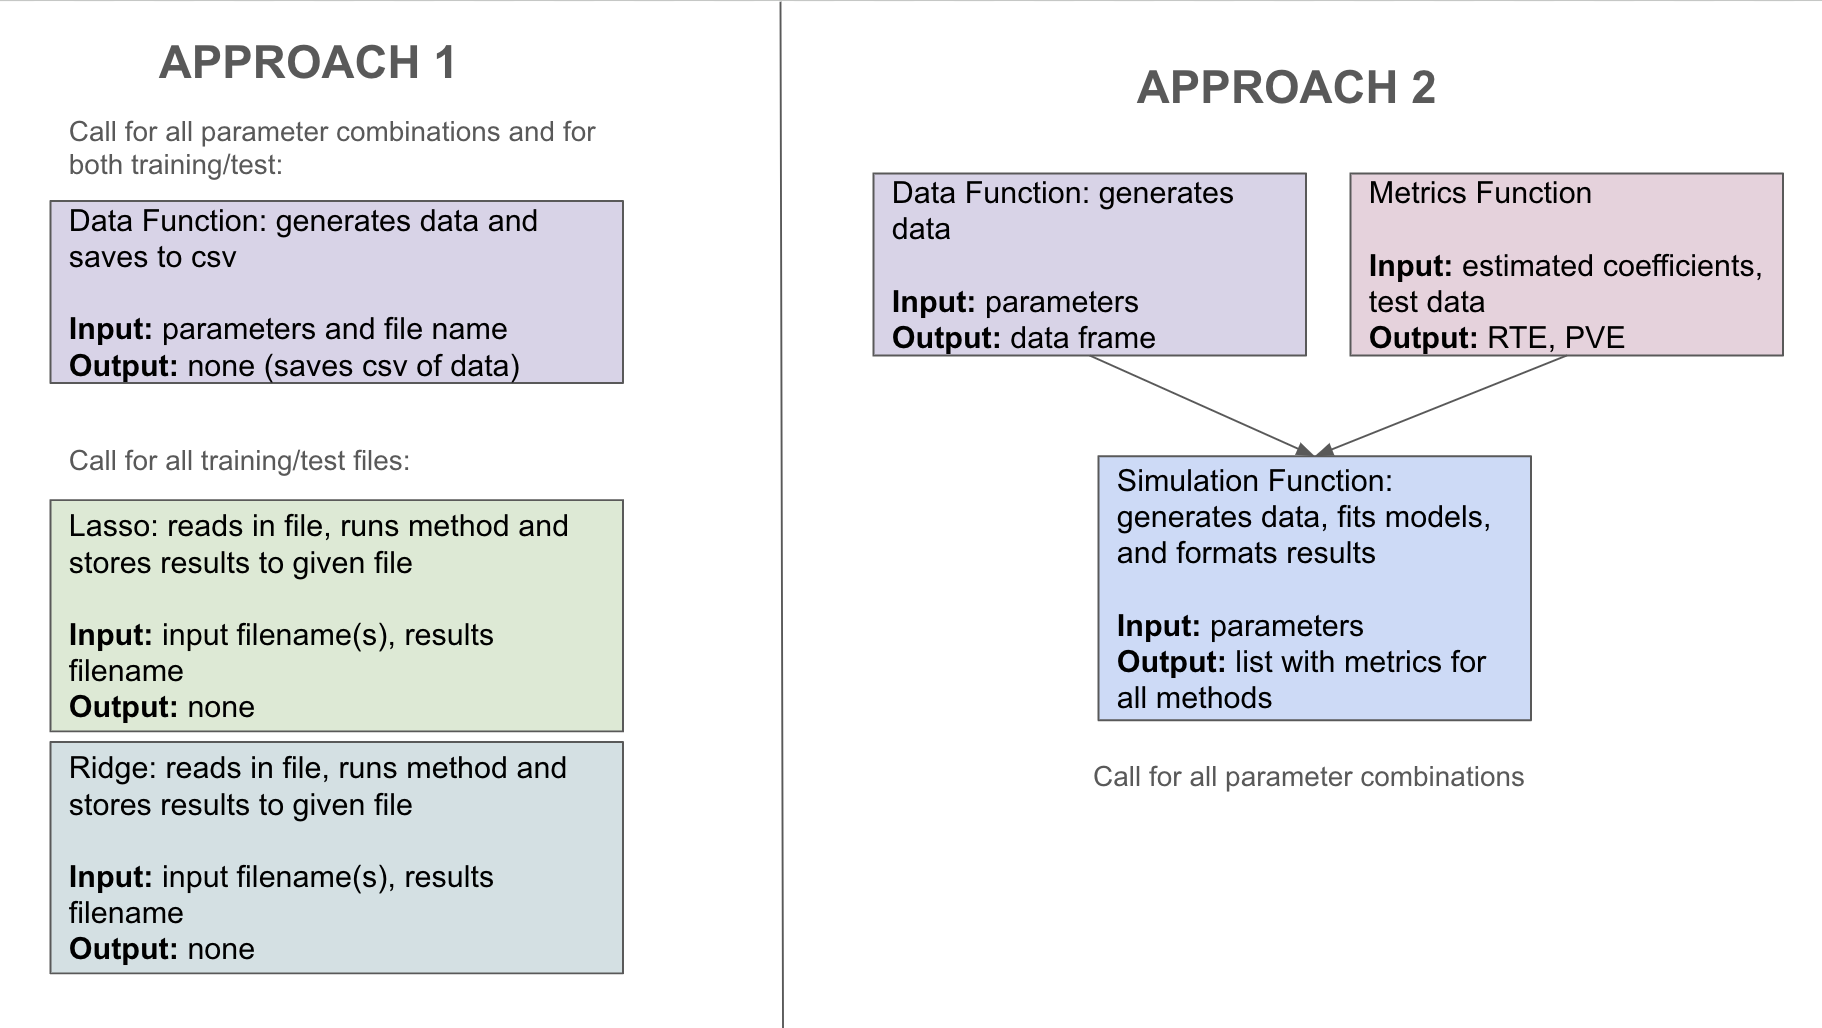
<figcaption>Figure 1: Example Approaches to Sketching out
Functions.</figcaption>
</figure>

Let’s take a closer look at the second approach. For our metrics
function, we have missed some inputs we will need. In particular, in
order to calculate our end metrics, we will need to know the true
coefficients $\beta$, the covariance matrix $\Sigma$, and the level of
noise $\sigma$. Therefore, rather than returning a data frame, we will
return a list that will contain $X$, $y$, and these values. For the
first approach, this would require saving this information in a text
file. Comparing between our two options, we will implement the second
approach that does not store data. Another thing we can notice in our
current sketch is that we likely want to store the results as a csv
file, so rather than returning a list, we should return a vector that
will correspond to a row in this file. Our final sketch is shown in
<a href="#fig-final-approach" class="quarto-xref">Figure 2</a>.

<figure id="fig-final-approach">
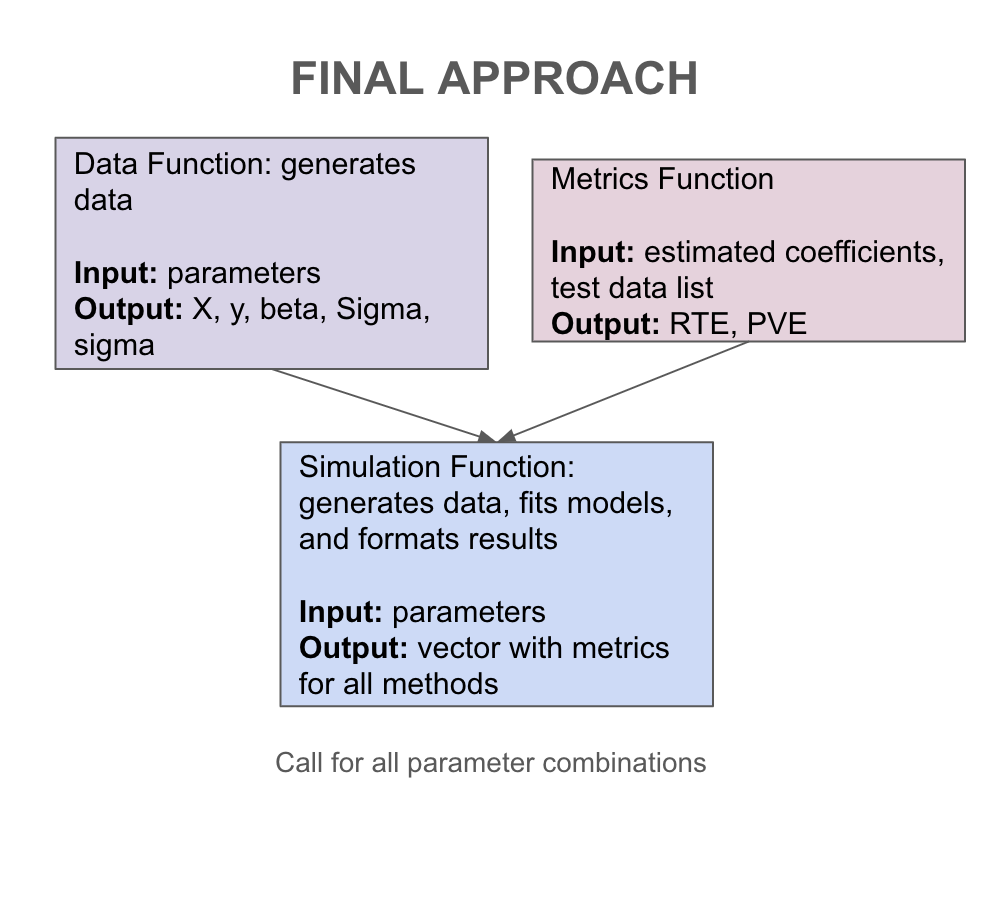
<figcaption>Figure 2: Updated Function Sketch.</figcaption>
</figure>

## Coding Our Simulation Study

We first load in the packages we will use. We will use the **MASS**
package for the `mvrnorm()` function, which generates data from a
multivariate normal distribution, we will use the **glmnet** package to
implement our lasso and ridge models, and we will use the **tidyverse**
and **patchwork** packages for summarizing and plotting the results.

In [ ]:
library(MASS) 
library(tidyverse) 
library(patchwork) 
library(glmnet)  

We start by writing our function to generate our data. Our input here
will be the parameters $n$, $p$, $s$, $\rho$, and $\nu$ and our output
will be a list.

In [ ]:
#' Simulate data
#'
#' @param n Number of observations
#' @param p Number of variables
#' @param s Sparsity level (number of non-zero coefficients)
#' @param snr Signal-to-noise ratio
#' @param rho Predictor correlation level
#' @return List containing simulated covariate matrix `X`, 
#' outcome vector `y`, true coefficient vector `beta`, 
#' covariate matrix `Sigma`, and variance of y `sigma`
simulate_data <- function(n, p, s, snr, rho) {
  
  # Generate covariance matrix
  cov_mat = matrix(0, nrow = p, ncol = p)
  for (row in 1:p) {
    for (col in 1:p) {
      cov_mat[row, col] = rho^(abs(row-col))
    }
  }
  
  # Generate X 
  x <- mvrnorm(n=n, mu=rep(0,p), Sigma = cov_mat)

  # Generate beta values 
  b <- rep(0, p)
  b[1:s] <- 1
 
  # find values
  mu <- x %*% b
  intercept <- -mean(mu)
  
  # Calculate variance
  var <- as.numeric((t(b) %*% cov_mat %*% b)/snr)

  # Generate y values
  y <- mvrnorm(mu = mu, Sigma = var*diag(n))
  
  return(list(X = x, y = y, beta = b, Sigma = cov_mat, sigma = var))
}

Next, we will write a function for our model metrics. The only input we
need from our model is the estimated coefficients. Otherwise, all of the
information comes from the data we generate with the function we just
wrote. We will utilize this list format to extract the values needed for
our formulas.

In [ ]:
#' Return model metrics
#'
#' @param coef_est Vector with estimated coefficients 
#' @param test_data Withheld test set (`simulate_data()` output)
#' @return Vector with relative test error (RTE) and proportion 
#' of variance explained (PVE). 
get_metrics <- function(coef_est, test_data) {
  
  # Extract out values needed
  coef_true <- test_data$beta
  Sigma <- test_data$Sigma
  var_y <- test_data$sigma

  # Calculate relative test error
  RTE <- (t(coef_est - coef_true) %*% Sigma %*% 
            (coef_est - coef_true) + var_y) / 
            var_y
    
  # Calculate PVE
  # Proportion of variance explained
  PVE <- 1 - (t(coef_est - coef_true) %*% Sigma %*%
                (coef_est - coef_true) + var_y) / 
    (var_y + t(coef_true %*% Sigma %*% coef_true))

  
  return(c(RTE = RTE, PVE = PVE))
}

Next, we will write a function that takes in the given parameters, fits
the two models, and outputs the evaluation metrics. In this case, we
will let the parameters be a named vector that contains all the
components needed for the data simulation. We will also include an
optional argument to set the random seed. In the code below, we find the
time it takes to fit each model using `Sys.time()`. This function finds
the current system time. Therefore, we can find the difference between
them using the `difftime()` function. We also make sure to format the
lasso and ridge results in the same manner.

In [ ]:
#' Model selection simulation
#'
#' @param params named vector containing all parameters needed for 
#' data generation (rho, snr, n, p, s)
#' @param seed (optional) random seed to set before setting folds, 
#' by default not used
#' @return Vector with parameter values, results
model_selection <- function(params, seed = NULL) {
  
  # Extract out parameters
  n <- params['n']
  p <- params['p']
  s <- params['s']
  snr <- params['snr']
  rho <- params['rho']

  # Generate training and test data
  train <- simulate_data(n, p, s, snr, rho)
  test <- simulate_data(n, p, s, snr, rho)
  
  # Set folds, if needed
  if (!is.null(seed)){
    set.seed(seed)
  }
  k <- 5
  folds <- sample(1:k, nrow(train$X), replace=TRUE)
  
  # Lasso model
  start_lasso <- Sys.time()
  lasso_cv <- cv.glmnet(train$X, train$y, nfolds = k, foldid = folds, 
                           alpha = 1, family = "gaussian", 
                        intercept=FALSE) 
  lasso_mod <- glmnet(train$X, train$y, lambda = lasso_cv$lambda.min,
                      alpha = 1, family = "gaussian", intercept=FALSE)
  end_lasso <- Sys.time()
  
  # Get lasso results
  lasso_time <- as.numeric(difftime(end_lasso, start_lasso, 
                                    units = "secs"))
  lasso_results <- c(lasso_time, 
                     get_metrics(coef(lasso_mod)[-1], test))
  names(lasso_results) <- c("lasso_sec", "lasso_RTE", "lasso_PVE")
  
  # Ridge model 
  start_ridge <- Sys.time()
  ridge_cv <- cv.glmnet(train$X, train$y, nfolds = k, foldid = folds, 
                        alpha = 0, family = "gaussian", 
                        intercept=FALSE)
  ridge_mod <- glmnet(train$X, train$y, lambda = ridge_cv$lambda.min,
                      alpha = 0, family = "gaussian", intercept=FALSE)
  end_ridge <- Sys.time()
  
  # Get ridge results
  ridge_time <- as.numeric(difftime(end_ridge, start_ridge, 
                                    units = "secs"))
  ridge_results <- c(ridge_time, 
                     get_metrics(coef(ridge_mod)[-1], test))
  names(ridge_results) <- c("ridge_sec", "ridge_RTE", "ridge_PVE")
  
  # Full results
  res <- c(n, p, s, snr, rho, lasso_results, ridge_results)
  
  return(res)
}

## Results

Now it’s time to run our simulation! We first need to find the
combinations of parameters we want to use in our simulation design. In
our case, we will set $n = 500$, $\rho = 0.35$, and $s = 10$. We will
vary $p \in \{50, 100\}$ and the signal-to-noise ratio
$\nu \in \{0.1, 0.5, 1.5\}$. We also want to run each possible
combination of parameters ten times so that we can average across the
results. We use the `expand.grid()` function to create a matrix that
contains a row for each simulation.

In [ ]:
# Set up parameter grid
rho_grid <- c(0.35)
snr_grid <- c(0.1, 0.5, 1.5)
n_grid <- c(500)
p_grid <- c(50, 100)
s_grid = c(10)
iter_grid <- 1:5
param_grid <- expand.grid(rho = rho_grid, snr = snr_grid, n = n_grid,
                          p = p_grid, s = s_grid, iter = iter_grid)

# convert to numeric
param_grid <- as.matrix(param_grid)
head(param_grid)

      rho snr   n   p  s iter
[1,] 0.35 0.1 500  50 10    1
[2,] 0.35 0.5 500  50 10    1
[3,] 0.35 1.5 500  50 10    1
[4,] 0.35 0.1 500 100 10    1
[5,] 0.35 0.5 500 100 10    1
[6,] 0.35 1.5 500 100 10    1

Recall that our main function took in a named vector that contained all
needed parameters. This allows us to use an `apply()` function to run
our simulation. In order to summarize by method, we pivot the results to
a longer form with a column for method.

In [ ]:
# Run experiments
results <- apply(param_grid, 1, model_selection) %>% t() 

# Convert to long data frame
results <- as.data.frame(results) %>% 
  pivot_longer(cols = starts_with(c("lasso", "ridge")),
               names_to = c("method", ".value"), names_sep="_")

Finally, we summarize our results. For example, we can create a table
with the average time for each method grouped by the data dimensions. We
observe that ridge regression was slower on average than lasso.

In [ ]:
avg_time <- results %>%
  group_by(method, n, p) %>%
  summarize(avg_seconds = round(mean(sec),3)) %>%
  ungroup()

`summarise()` has grouped output by 'method', 'n'. You can override using the
`.groups` argument.

# A tibble: 4 × 4
  method     n     p avg_seconds
  <chr>  <dbl> <dbl>       <dbl>
1 lasso    500    50       0.018
2 lasso    500   100       0.028
3 ridge    500    50       0.021
4 ridge    500   100       0.043

We can also create summary plots of our evaluation metrics similar to
@hastie2020best. To do so, we create one last function that will create
a plot of the relative test error and percentage of variance explained
across different signal-to-noise ratios. This allows us to regenerate
this plot for different parameter settings.

`summarise()` has grouped output by 'method'. You can override using the
`.groups` argument.

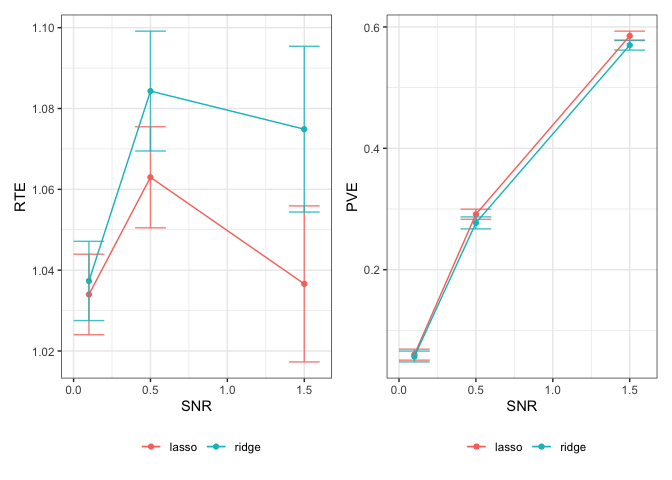

In [ ]:
#' Generate RTE and PVE plots for a given set of parameters
#'
#' @param results Data frame with simulation results  
#' @param n_input Number of observations
#' @param p_input Number of variables
#' @param s_input Sparsity level
#' @return ggplot object
generate_plot <- function(results, n_input, p_input, s_input) {
 
  setting <- results %>%
    filter(n == n_input, p == p_input, s == s_input) %>%
    group_by(method, snr) %>%
    summarize(mean_RTE = mean(RTE, na.rm = TRUE), 
              sd_RTE = sd(RTE, na.rm = TRUE),
              mean_PVE = mean(PVE, na.rm = TRUE), 
              sd_PVE = sd(PVE, na.rm = TRUE))

  rte_plot <- ggplot(setting) + 
    geom_point(aes(x = snr, y = mean_RTE, color = method)) + 
    geom_errorbar(aes(x = snr, ymin = mean_RTE - sd_RTE, 
                      ymax = mean_RTE + sd_RTE, color = method),
                  alpha = 0.8, width = 0.2) + 
    geom_line(aes(x = snr, y = mean_RTE, color = method)) + 
    theme_bw() + 
    theme(legend.position = "bottom") + 
    labs(x = "SNR", y = "RTE", color = "")
  
  
  pve_plot <- ggplot(setting) + 
    geom_point(aes(x = snr, y = mean_PVE, color = method)) + 
    geom_errorbar(aes(x = snr, ymin = mean_PVE - sd_PVE, 
                      ymax = mean_PVE + sd_PVE, color = method),
                  alpha = 0.8, width = 0.2) + 
    geom_line(aes(x = snr, y = mean_PVE, color = method)) + 
    theme_bw() + 
    theme(legend.position = "bottom") + 
    labs(x = "SNR", y = "PVE", color = "")

  full_plot <- rte_plot + pve_plot 
  
  return(full_plot)
}
generate_plot(results, 500, 50, 10)

`summarise()` has grouped output by 'method'. You can override using the
`.groups` argument.

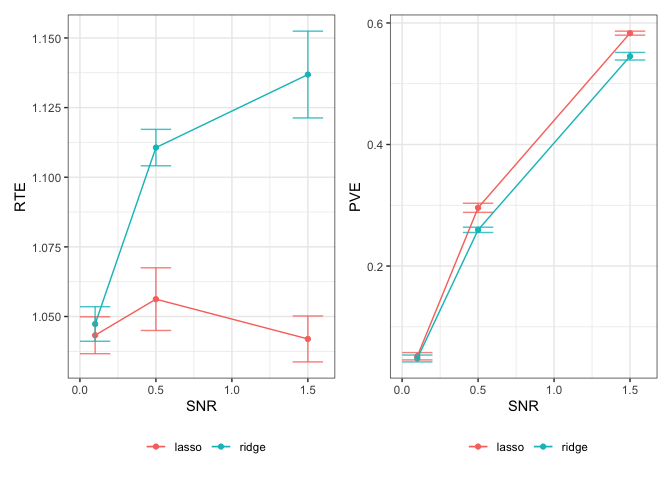

In [ ]:
generate_plot(results, 500, 100, 10)